# 5.1 Technological Setup

In [1]:
!pip install numpy pandas matplotlib seaborn scipy statsmodels prophet openpyxl --quiet


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from itertools import cycle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import find_peaks
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# 5.2 Data Cleaning and Imputation

In [3]:
df_2023_2024 = pd.read_excel("KhalsaGarments2023to2024.xlsx")
df_2024_2025 = pd.read_excel("KhalsaGarments2024to2025.xlsx")
# Change data types of numeric and datetime columns
for df in [df_2023_2024, df_2024_2025]:
    for col in [
        "Production Quantity",
        "Sales Quantity",
        "Inventory Quantity",
        "Revenue",
    ]:
        df[col].replace("-", 0, inplace=True)
        df[col] = df[col].astype(float)
    df["Date"] = pd.to_datetime(df["Date"])
# Merge the two dataframes
merged_df = pd.concat([df_2023_2024, df_2024_2025])

# Impute missing values in numeric columns with the median value
numeric_cols = [
    "Production Quantity",
    "Sales Quantity",
    "Inventory Quantity",
    "Revenue",
]
for col in numeric_cols:
    merged_df[col].fillna(merged_df[col].median(), inplace=True)

merged_df["Week"] = merged_df["Date"].dt.to_period("W").apply(lambda r: r.start_time)
merged_df["Month"] = merged_df["Date"].dt.to_period("M").apply(lambda r: r.start_time)
merged_df["Year"] = merged_df["Date"].dt.to_period("Y").apply(lambda r: r.start_time)

# Drop the rows with missing values in the 'Date' column
merged_df.dropna(subset=["Date"], inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 392
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 797 non-null    datetime64[ns]
 1   Product Name         797 non-null    object        
 2   Segment              797 non-null    object        
 3   Color                797 non-null    object        
 4   Pattern              797 non-null    object        
 5   Production Quantity  797 non-null    float64       
 6   Sales Quantity       797 non-null    float64       
 7   Inventory Quantity   797 non-null    float64       
 8   Price                797 non-null    int64         
 9   Revenue              797 non-null    float64       
 10  Week                 797 non-null    datetime64[ns]
 11  Month                797 non-null    datetime64[ns]
 12  Year                 797 non-null    datetime64[ns]
dtypes: datetime64[ns](4), float64(4), i

In [4]:
merged_df.head()

,Date,Product Name,Segment,Color,Pattern,Production Quantity,Sales Quantity,Inventory Quantity,Price,Revenue,Week,Month,Year
0,2023-01-02,Track Suit,Men,"Charcoal, Black, Brown",Minimal Print,14.0,0.0,15.0,650,0.0,2023-01-02,2023-01-01,2023-01-01
1,2023-01-02,Hoodie,Men,"Navy Blue, Black, Dark Gray","Quilted, Animal Print",13.0,0.0,18.0,500,0.0,2023-01-02,2023-01-01,2023-01-01
2,2023-01-02,Sweat Shirt,Men,"Brown, White",Printed,14.0,0.0,17.0,450,0.0,2023-01-02,2023-01-01,2023-01-01
3,2023-01-02,Windcheater,Men,"Black, White, Dark Gray, Charcoal, Navy Blue",Quilted,13.0,0.0,18.0,350,0.0,2023-01-02,2023-01-01,2023-01-01
4,2023-01-02,T Shirt,Men,"Olive Green, Black, White","Striped, Gradient",33.0,0.0,40.0,200,0.0,2023-01-02,2023-01-01,2023-01-01


In [5]:
unique_colors = len(
    set(color.strip() for colors in merged_df["Color"] for color in colors.split(","))
)
unique_patterns = len(
    set(
        color.strip()
        for patterns in merged_df["Pattern"]
        for color in patterns.split(",")
    )
)
unique_product_names = len(set(merged_df["Product Name"]))

print(f"Unique colors: {unique_colors}")
print(f"Unique patterns: {unique_patterns}")
print(f"Unique product names: {unique_product_names}")

Unique colors: 17
Unique patterns: 37
Unique product names: 11


In [6]:
print(list(set(merged_df["Product Name"])))

['T Shirt', 'T Shirt (Kids)', 'Joggers', 'Windcheater', 'Shirt (Kids)', 'Hoodie', 'Shirt', 'Sweat Shirt', 'Track Suit', 'Shorts', 'Shorts (Kids)']


#  5.3 Exploratory Data Analysis (EDA)

In [7]:
# Define the numerical and categorical columns
numeric_cols = [
    "Production Quantity",
    "Sales Quantity",
    "Inventory Quantity",
    "Price",
    "Revenue",
]
categorical_cols = ["Product Name", "Segment", "Color", "Pattern"]

### 1. Univariate Analysis

#### 1.1. Distribution of Numeric Variables

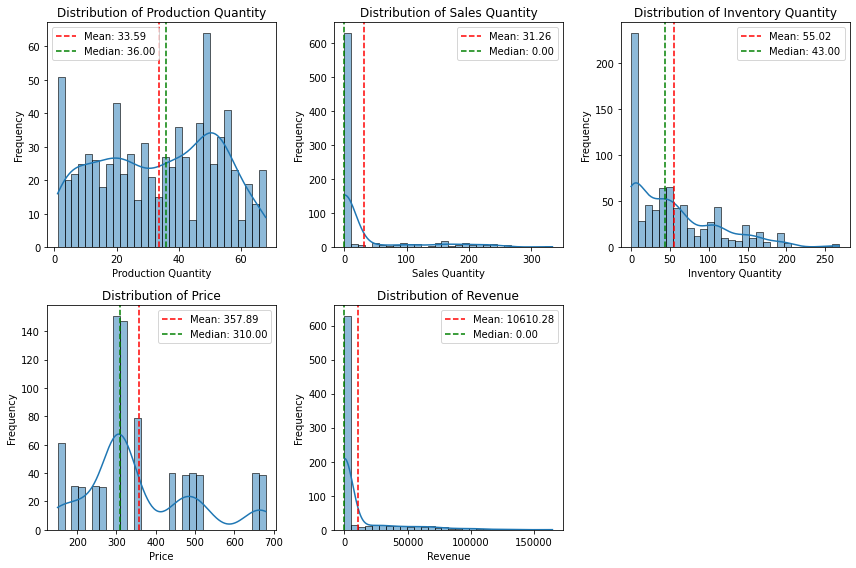

In [8]:
"""
Here I am showing central tendency measures and dispersion measures, so in a way the complete
descriptive statistics of the numeric columns in the dataset.
"""

fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to iterate easily

for i, col in enumerate(numeric_cols):
    sns.histplot(merged_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].axvline(
        merged_df[col].mean(),
        color="red",
        linestyle="--",
        label=f"Mean: {merged_df[col].mean():.2f}",
    )
    axes[i].axvline(
        merged_df[col].median(),
        color="green",
        linestyle="--",
        label=f"Median: {merged_df[col].median():.2f}",
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

if len(numeric_cols) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### 1.2. Summary statistics for Numerical Variables

In [9]:
summary_stats = merged_df[numeric_cols].describe()
summary_stats

,Production Quantity,Sales Quantity,Inventory Quantity,Price,Revenue
count,797.000000,797.000000,797.000000,797.000000,797.000000
mean,33.589711,31.263488,55.015056,357.892095,10610.276035
std,19.103488,70.027388,55.230488,140.356951,25251.653002
min,1.000000,0.000000,0.000000,150.000000,0.000000
25%,17.000000,0.000000,5.000000,300.000000,0.000000
50%,36.000000,0.000000,43.000000,310.000000,0.000000
75%,50.000000,0.000000,86.000000,450.000000,0.000000
max,68.000000,334.000000,268.000000,680.000000,164560.000000


#### 1.3. Frequency Analysis for Categorical Variables

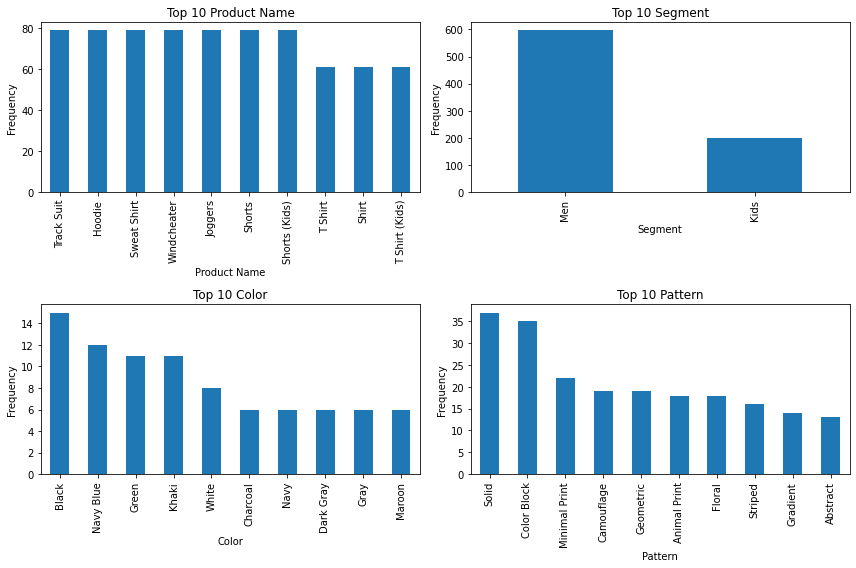

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to iterate easily

for i, col in enumerate(categorical_cols):
    merged_df[col].value_counts().head(10).plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Top 10 {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### 2. Bivariate Analysis

#### 2.1 Correlation matrix between Numerical Variables

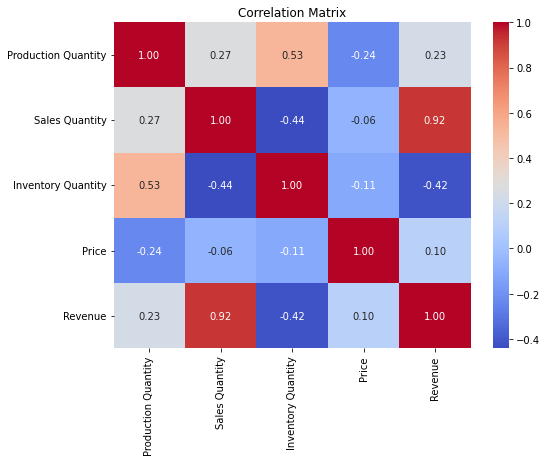

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### 2.2. Relationship mapping between Numerical Variables

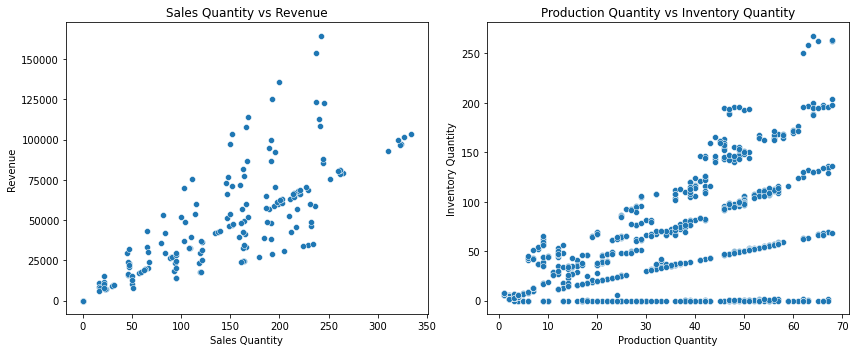

In [12]:
# sns.pairplot(merged_df[numeric_cols])
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
sns.scatterplot(x="Sales Quantity", y="Revenue", data=merged_df, ax=axes[0])
axes[0].set_title("Sales Quantity vs Revenue")
sns.scatterplot(
    x="Production Quantity", y="Inventory Quantity", data=merged_df, ax=axes[1]
)
axes[1].set_title("Production Quantity vs Inventory Quantity")

plt.tight_layout()
plt.show()

#### 2.3. Interdependence Exploration between Product Segments using BoxPlots

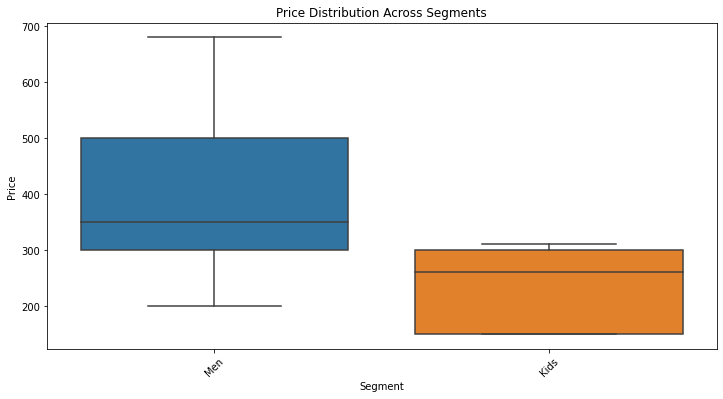

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Segment", y="Price", data=merged_df)
plt.title("Price Distribution Across Segments")
plt.xticks(rotation=45)
plt.show()

### 3. Temporal Analysis

#### 3.1 Time Series pattern identification and Seasonal Sales Trend

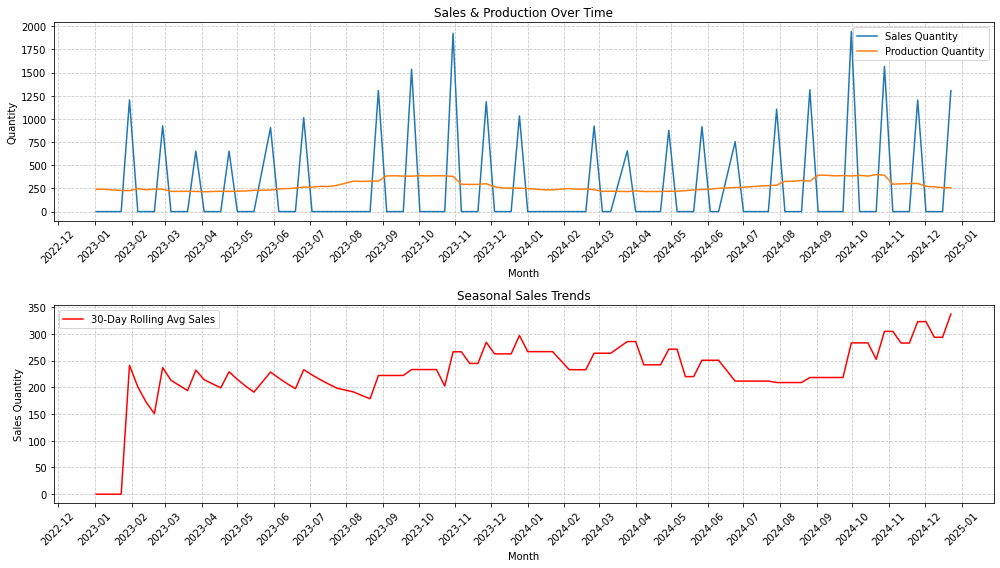

In [14]:
# Ensure Date is unique by aggregating (sum for quantities, mean for revenue)
# This is because we are calculating overall trends, and if we don't do this data will be too "granular"
merged_df_agg = (
    merged_df.groupby("Date", as_index=False)
    .agg(
        {
            "Production Quantity": "sum",
            "Sales Quantity": "sum",
            "Inventory Quantity": "sum",
            "Price": "mean",
            "Revenue": "sum",
        }
    )
    .sort_values(by="Date")
)

# Convert Date to Monthly Period Format for Better Readability
# merged_df_agg['Month'] = merged_df_agg['Date'].dt.to_period('M').astype(str)  # Convert to 'YYYY-MM' format
fig, axes = plt.subplots(2, 1, figsize=(14, 8))  # 2 rows, 1 column

# Sales & Production Over Time
sns.lineplot(
    data=merged_df_agg, x="Date", y="Sales Quantity", ax=axes[0], label="Sales Quantity"
)
sns.lineplot(
    data=merged_df_agg,
    x="Date",
    y="Production Quantity",
    ax=axes[0],
    label="Production Quantity",
)
axes[0].set_title("Sales & Production Over Time")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Quantity")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[0].tick_params(axis="x", rotation=45)

# Calculate rolling mean (smoothens out short-term fluctuations to help identify long-term trends)
merged_df_agg["Sales Quantity Rolling"] = (
    merged_df_agg["Sales Quantity"].rolling(window=30, min_periods=1).mean()
)
# Seasonal Sales Trends with Rolling Average
axes[1].plot(
    merged_df_agg["Date"],
    merged_df_agg["Sales Quantity Rolling"],
    color="red",
    label="30-Day Rolling Avg Sales",
)
axes[1].set_title("Seasonal Sales Trends")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Sales Quantity")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

#### 3.2 Periodicity Investigation using FFT

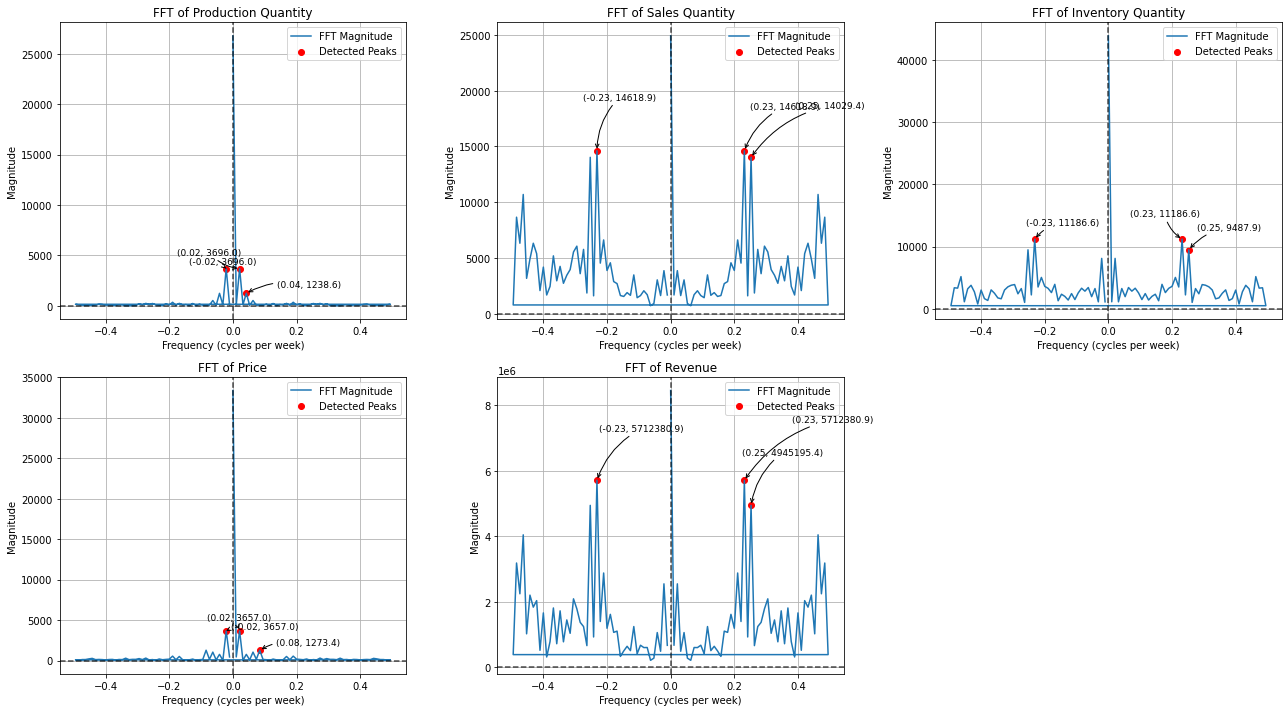

In [15]:
"""HOW TO READ AN FFT PLOT?
x-axis shows the frequency components, with 0 being the lowest frequency (the average value).
y-axis shows the amplitude of each frequency component.
The peaks in the FFT plot indicate the dominant frequencies present in the signal.
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easier indexing
PEAKS_TO_SHOW = 3

for i, col in enumerate(numeric_cols):
    # Apply FFT
    fft_values = np.fft.fft(merged_df_agg[col])
    frequencies = np.fft.fftfreq(len(fft_values))
    # Take absolute values to get magnitude spectrum
    magnitude = np.abs(fft_values)
    # Find peaks
    peaks, _ = find_peaks(magnitude, height=50)
    top_peaks = sorted(peaks, key=lambda x: magnitude[x], reverse=True)[:PEAKS_TO_SHOW]

    # Plot FFT with peaks
    axes[i].plot(frequencies, magnitude, label="FFT Magnitude")
    axes[i].scatter(
        frequencies[top_peaks],
        magnitude[top_peaks],
        color="red",
        marker="o",
        label="Detected Peaks",
    )
    axes[i].set_title(f"FFT of {col}")
    axes[i].set_xlabel("Frequency (cycles per week)")
    axes[i].set_ylabel("Magnitude")
    axes[i].axvline(0, color="black", linestyle="--", alpha=0.7)
    axes[i].axhline(0, color="black", linestyle="--", alpha=0.7)
    axes[i].legend()
    axes[i].grid(True)

    # Annotate peaks
    vertical_alignments = cycle(["bottom", "top", "bottom"])
    horizontal_offsets = np.random.uniform(-0.2, 0.2, PEAKS_TO_SHOW)

    for j, peak in enumerate(top_peaks[:PEAKS_TO_SHOW]):
        x, y = frequencies[peak], magnitude[peak]
        axes[i].annotate(
            f"({x:.2f}, {y:.1f})",
            (x, y),
            xytext=(x + horizontal_offsets[j], y * 1.3),  # Offset text
            textcoords="data",
            verticalalignment=next(vertical_alignments),
            horizontalalignment="left",
            fontsize=9,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"),
        )

# Remove the last empty subplot if fewer than 6 plots are used
if len(numeric_cols) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# 5.4 Historical Data Anslysis

### Weekly Proudction, Montly Sales and Montly Revenue over time

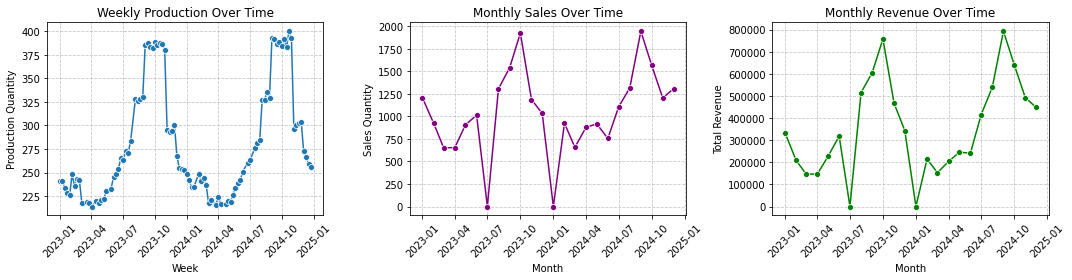

Top 5 Peak Sales Periods:
        Month  Sales Quantity
20 2024-09-01          1945.0
9  2023-10-01          1924.0
21 2024-10-01          1568.0
8  2023-09-01          1538.0
19 2024-08-01          1315.0


In [16]:
weekly_production = merged_df.groupby("Week")["Production Quantity"].sum().reset_index()
monthly_sales = merged_df.groupby("Month")["Sales Quantity"].sum().reset_index()
monthly_revenue = merged_df.groupby("Month")["Revenue"].sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()

# Weekly Production Quantity Plot
sns.lineplot(
    data=weekly_production, x="Week", y="Production Quantity", marker="o", ax=axes[0]
)
axes[0].set_title("Weekly Production Over Time")
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Production Quantity")
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Monthly Sales Quantity Plot
sns.lineplot(
    data=monthly_sales,
    x="Month",
    y="Sales Quantity",
    marker="o",
    color="purple",
    ax=axes[1],
)
axes[1].set_title("Monthly Sales Over Time")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Sales Quantity")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True, linestyle="--", alpha=0.7)


sns.lineplot(
    data=monthly_revenue,
    x="Month",
    y="Revenue",
    marker="o",
    color="green",
    ax=axes[2],
)
axes[2].set_title("Monthly Revenue Over Time")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Total Revenue")
axes[2].tick_params(axis="x", rotation=45)
axes[2].grid(True, linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

peak_sales = monthly_sales.sort_values(by="Sales Quantity", ascending=False).head(5)
print("Top 5 Peak Sales Periods:")
print(peak_sales[["Month", "Sales Quantity"]])

### Revenue by Product and Production Quantity by Product

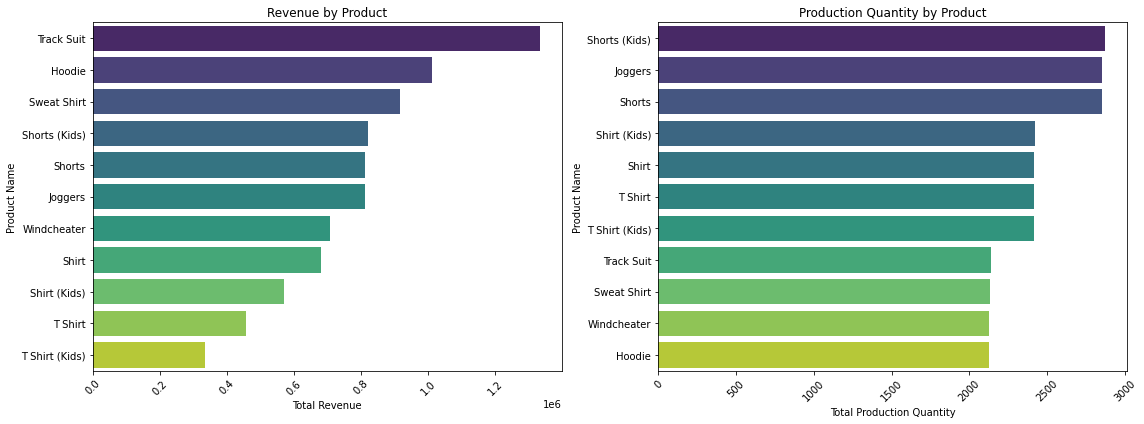

In [17]:
# Group data for Revenue by Product
product_revenue = (
    merged_df.groupby("Product Name")["Revenue"]
    .sum()
    .reset_index()
    .sort_values(by="Revenue", ascending=False)
)
# Group data for Production Quantity by Product
product_production = (
    merged_df.groupby("Product Name")["Production Quantity"]
    .sum()
    .reset_index()
    .sort_values(by="Production Quantity", ascending=False)
)
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes.flatten()

# Bar chart: Revenue by Product
sns.barplot(
    data=product_revenue, x="Revenue", y="Product Name", palette="viridis", ax=axes[0]
)
axes[0].set_xlabel("Total Revenue")
axes[0].set_ylabel("Product Name")
axes[0].set_title("Revenue by Product")
axes[0].tick_params(axis="x", rotation=45)

# Bar chart: Production Quantity by Product
sns.barplot(
    data=product_production,
    x="Production Quantity",
    y="Product Name",
    palette="viridis",
    ax=axes[1],
)
axes[1].set_xlabel("Total Production Quantity")
axes[1].set_ylabel("Product Name")
axes[1].set_title("Production Quantity by Product")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Sales by Segment

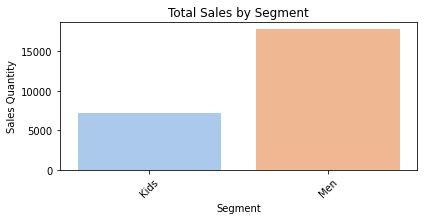

In [18]:
segment_sales = merged_df.groupby("Segment")["Sales Quantity"].sum().reset_index()

plt.figure(figsize=(6, 3))
sns.barplot(data=segment_sales, x="Segment", y="Sales Quantity", palette="pastel")
plt.xlabel("Segment")
plt.title("Total Sales by Segment")
plt.ylabel("Sales Quantity")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

### Monthly Sales by Product

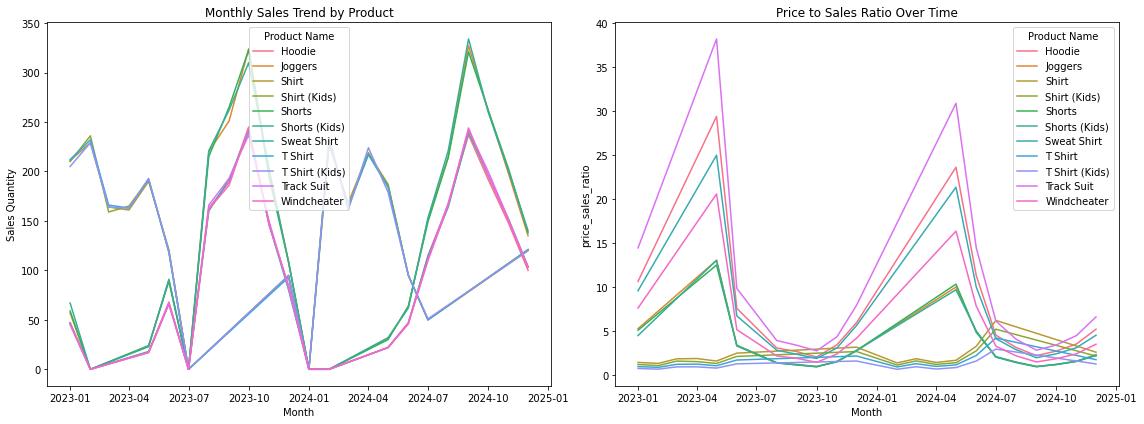

In [19]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes.flatten()

# Monthly sales trend - aggregating by Month
monthly_sales_by_product = (
    merged_df.groupby(["Month", "Product Name"])["Sales Quantity"].sum().reset_index()
)

sns.lineplot(
    data=monthly_sales_by_product,
    x="Month",
    y="Sales Quantity",
    hue="Product Name",
    ax=axes[0],
)
axes[0].set_title("Monthly Sales Trend by Product")


# Remove rows where Sales Quantity is 0 or null
valid_sales = merged_df[merged_df["Sales Quantity"] > 0].copy()
# Price-to-sales ratio trend
valid_sales["price_sales_ratio"] = valid_sales["Price"] / valid_sales["Sales Quantity"]
monthly_ratio = (
    valid_sales.groupby(["Month", "Product Name"])["price_sales_ratio"]
    .mean()
    .reset_index()
)

sns.lineplot(
    data=monthly_ratio, x="Month", y="price_sales_ratio", hue="Product Name", ax=axes[1]
)
axes[1].set_title("Price to Sales Ratio Over Time")

plt.tight_layout()
plt.show()

# # YoY comparison: grouping by year and month from the Date column
# monthly_total = merged_df.groupby([
#     merged_df['Date'].dt.year.rename('year'),
#     merged_df['Date'].dt.month.rename('month')
# ])['Sales Quantity'].sum().reset_index()

# monthly_total['month_year'] = monthly_total.apply(lambda x: f"{int(x['month'])}-{int(x['year'])}", axis=1)

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=monthly_total, x='month_year', y='Sales Quantity')
# plt.title('Year over Year Sales Comparison')
# plt.xticks(rotation=45)
# plt.tight_layout()

### Montly Color and Pattern Trends

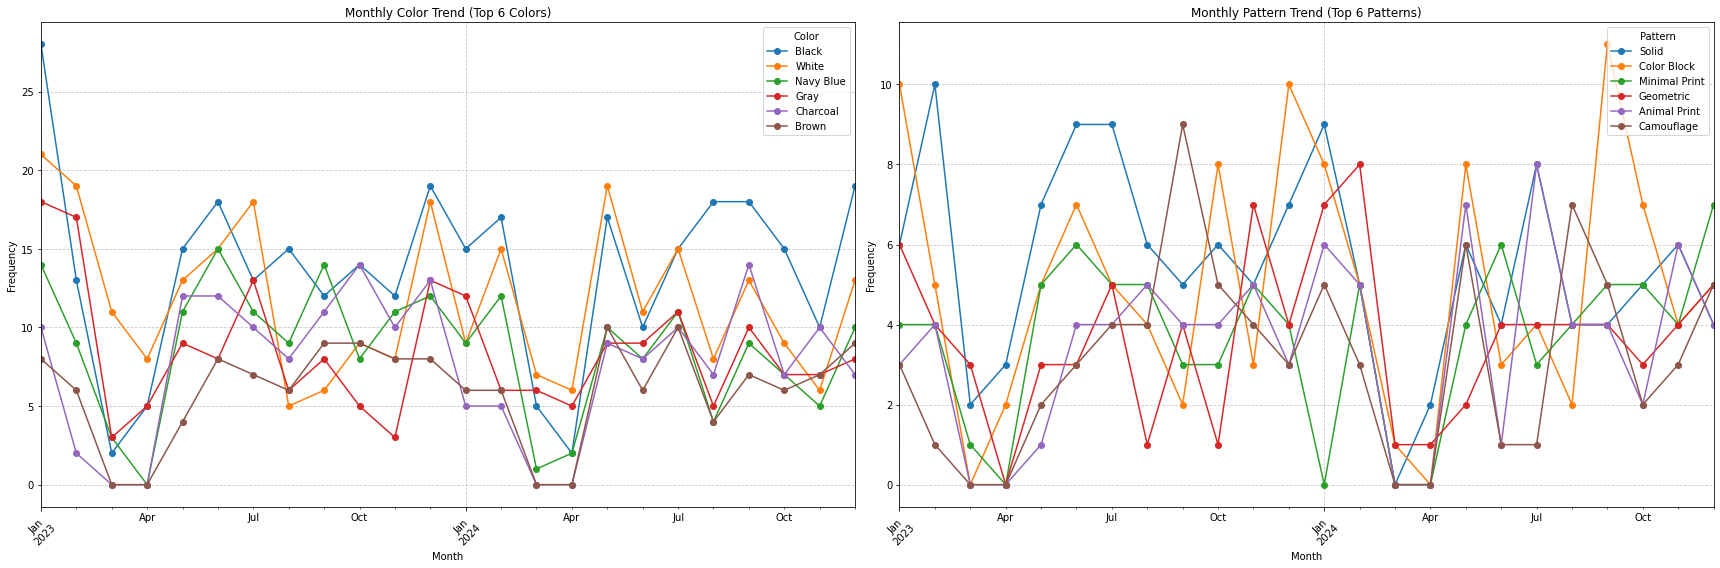

In [20]:
# ---- Monthly Color Trend (Limited to Top 6 Colors) ----
# Split the comma-separated 'Color' values and explode into separate rows
color_df = merged_df[["Month", "Color"]].copy()
color_df["Color"] = color_df["Color"].str.split(",")
color_df = color_df.explode("Color")
color_df["Color"] = color_df["Color"].str.strip()  # remove extra spaces
# Group by Month and Color, and count frequency
monthly_color_trend = (
    color_df.groupby(["Month", "Color"]).size().reset_index(name="Count")
)
# Pivot the table: Month as index, Color as columns
monthly_color_pivot = monthly_color_trend.pivot(
    index="Month", columns="Color", values="Count"
).fillna(0)
# Calculate overall frequency to determine top colors
overall_color_count = color_df.groupby("Color").size().reset_index(name="Total")
overall_color_count = overall_color_count.sort_values(by="Total", ascending=False)
top_colors = overall_color_count["Color"].head(6).tolist()
# Filter pivot table to only include top colors
monthly_color_pivot = monthly_color_pivot[top_colors]


# ---- Monthly Pattern Trend (Limited to Top 6 Patterns) ----
# Split the comma-separated 'Pattern' values and explode into separate rows
pattern_df = merged_df[["Month", "Pattern"]].copy()
pattern_df["Pattern"] = pattern_df["Pattern"].str.split(",")
pattern_df = pattern_df.explode("Pattern")
pattern_df["Pattern"] = pattern_df["Pattern"].str.strip()  # remove extra spaces
# Group by Month and Pattern, and count frequency
monthly_pattern_trend = (
    pattern_df.groupby(["Month", "Pattern"]).size().reset_index(name="Count")
)
# Pivot the table: Month as index, Pattern as columns
monthly_pattern_pivot = monthly_pattern_trend.pivot(
    index="Month", columns="Pattern", values="Count"
).fillna(0)
# Calculate overall frequency to determine top patterns
overall_pattern_count = pattern_df.groupby("Pattern").size().reset_index(name="Total")
overall_pattern_count = overall_pattern_count.sort_values(by="Total", ascending=False)
top_patterns = overall_pattern_count["Pattern"].head(6).tolist()
# Filter pivot table to only include top patterns
monthly_pattern_pivot = monthly_pattern_pivot[top_patterns]

# ---- Plot Both Trends Using Subplots ----
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
axes = axes.flatten()  # flatten the axes array for easier indexing

# Plot Monthly Color Trend
monthly_color_pivot.plot(ax=axes[0], marker="o")
axes[0].set_title("Monthly Color Trend (Top 6 Colors)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis="x", rotation=45)
axes[0].legend(title="Color")
axes[0].grid(True, linestyle="--", alpha=0.7)

# Plot Monthly Pattern Trend
monthly_pattern_pivot.plot(ax=axes[1], marker="o")
axes[1].set_title("Monthly Pattern Trend (Top 6 Patterns)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(title="Pattern")
axes[1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Time Series Analysis

### Seasonal Decomposition

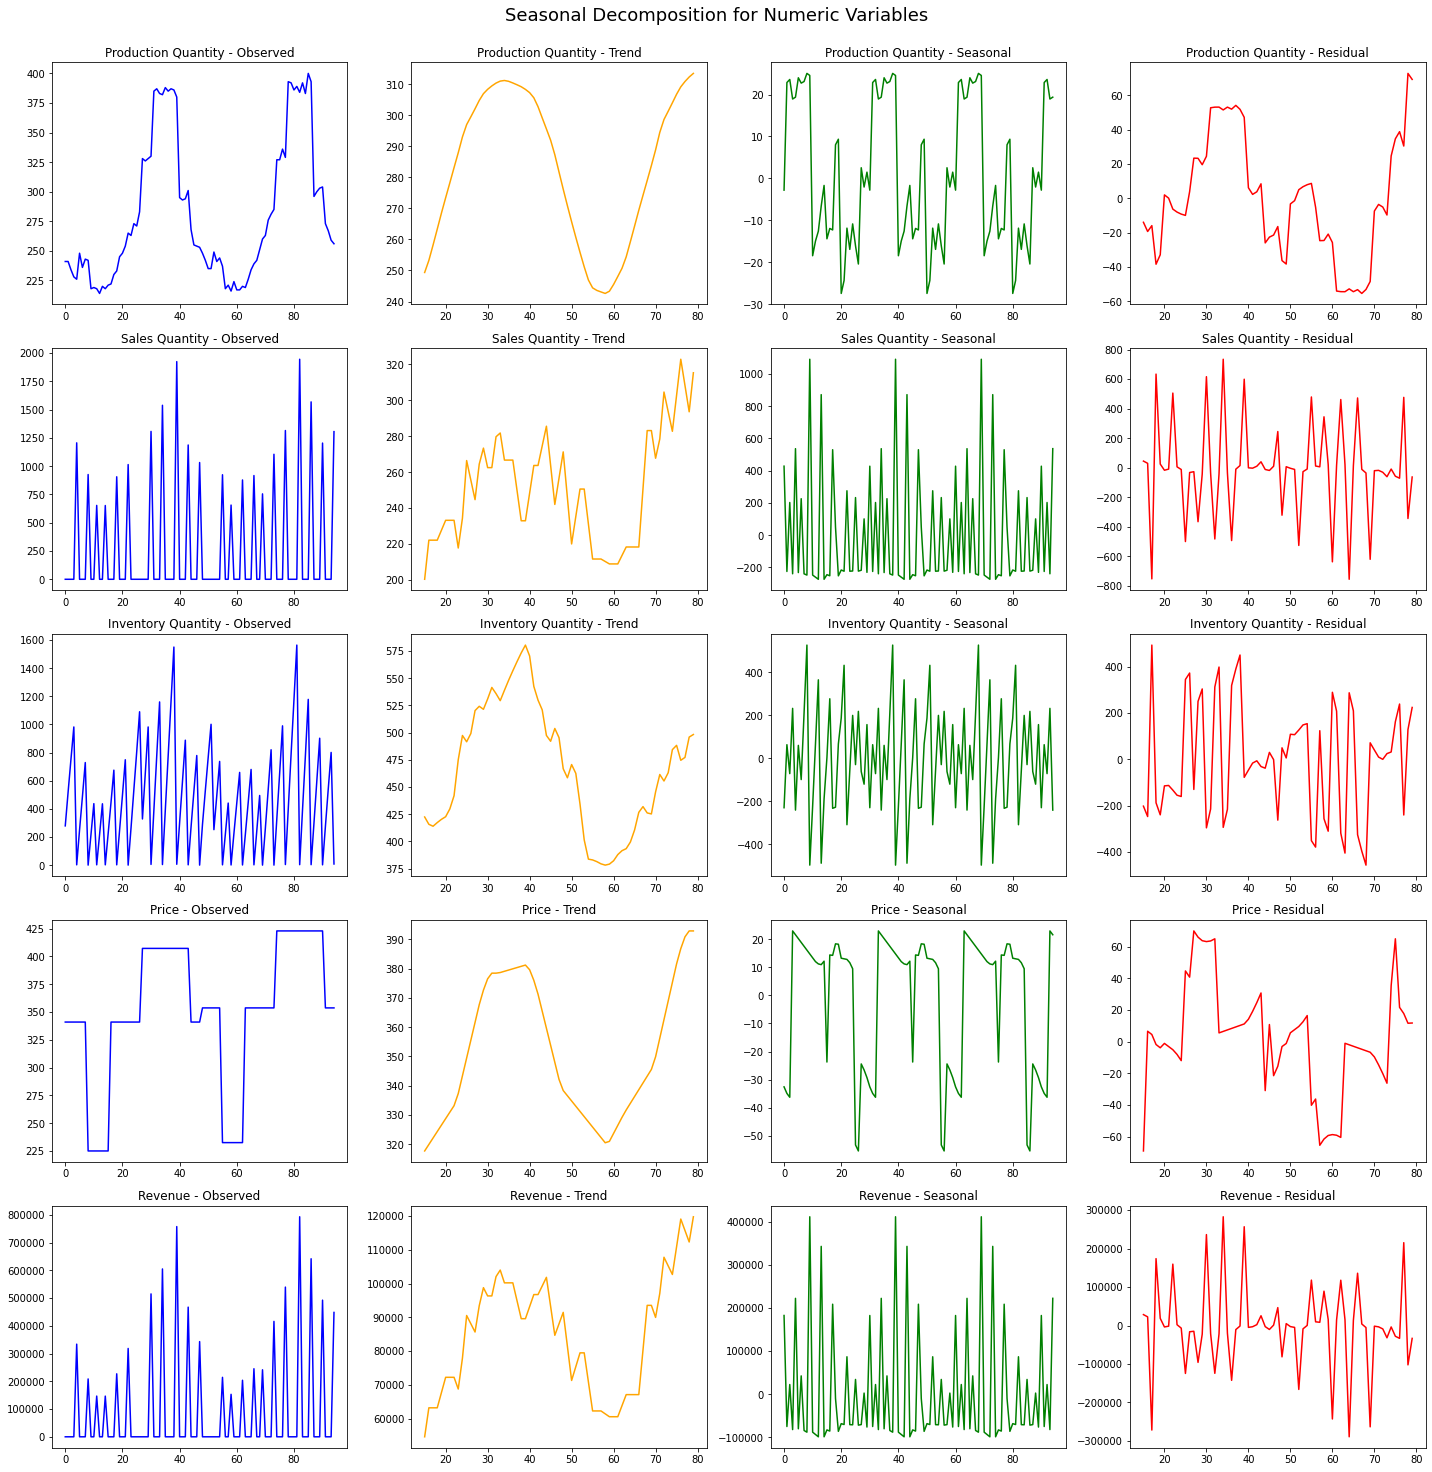

In [21]:
# Number of numeric columns
n_vars = len(numeric_cols)
# Create a subplot grid: rows = number of variables, columns = 4 (observed, trend, seasonal, residual)
fig, axes = plt.subplots(n_vars, 4, figsize=(20, 4 * n_vars))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # Perform seasonal decomposition on each numeric column
    decomposition = seasonal_decompose(merged_df_agg[col], model="additive", period=30)
    # Calculate the starting index for the current variable's subplots
    idx = i * 4
    # Plot each component
    axes[idx].plot(decomposition.observed, color="blue")
    axes[idx].set_title(f"{col} - Observed")
    axes[idx + 1].plot(decomposition.trend, color="orange")
    axes[idx + 1].set_title(f"{col} - Trend")
    axes[idx + 2].plot(decomposition.seasonal, color="green")
    axes[idx + 2].set_title(f"{col} - Seasonal")
    axes[idx + 3].plot(decomposition.resid, color="red")
    axes[idx + 3].set_title(f"{col} - Residual")
    # # Rotate x-axis labels for all four plots of this variable
    # for j in range(4):
    #     axes[idx + j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle("Seasonal Decomposition for Numeric Variables", fontsize=18, y=1.02)
plt.show()